In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = "C:/Users/A/Math608hw/healthcare-dataset-stroke-data.csv"
df= pd.read_csv(url)

In [5]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [9]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

C:\Users\A\AppData\Local\Temp\ipykernel_17372\3594416367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


In [11]:
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

In [13]:
# Define Features and Target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
svm_model = SVC(probability=True, kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_pred_svm)

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_rf)

In [21]:
# Step 3: XGBoost with Hyperparameter Tuning
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb_model, xgb_params, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [23]:
xgb_optimized = grid_search.best_estimator_
y_pred_xgb = xgb_optimized.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

In [25]:
models = ['SVM', 'Random Forest', 'XGBoost']
auc_scores = [auc_svm, auc_rf, auc_xgb]
print(auc_scores)

[0.5425925925925925, 0.8128909465020576, 0.837037037037037]


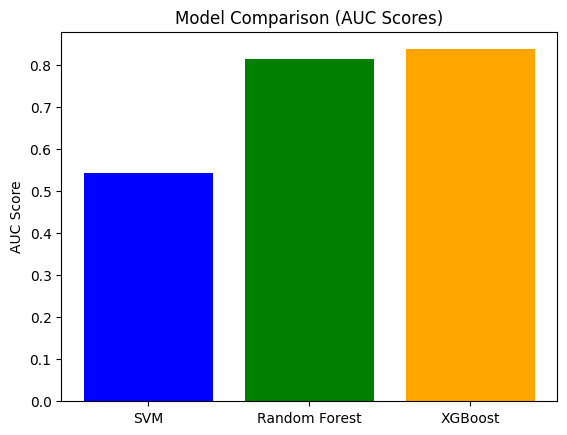

In [27]:
plt.bar(models, auc_scores, color=['blue', 'green', 'orange'])
plt.title('Model Comparison (AUC Scores)')
plt.ylabel('AUC Score')
plt.show()

In [49]:
print("Best Parameters for XGBoost:", grid_search.best_params_)
print(f"AUC Scores -> SVM: {auc_svm:.4f}, Random Forest: {auc_rf:.4f}, XGBoost: {auc_xgb:.4f}")

Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
AUC Scores -> SVM: 0.5426, Random Forest: 0.8129, XGBoost: 0.8370
